### Portfolio Optimization

This notebook aims at applying the fundmentals of [Modern Portfolio Optimization](https://www.investopedia.com/terms/m/modernportfoliotheory.asp). This approach, hypothetized by Nobel-winning economist Harry Markwoitz, was devised to provide investors with a plan to construct diversified portoflios that yield the maximum returns possible while keeping risk under control. There are two main statistical operations at play when constructing a portoflio under these coordinates, those are the variance and the correlation. For that, the [Sharpe Ratio](https://www.investopedia.com/terms/s/sharperatio.asp) will be used. 

In containing risk, it is adviseable to diversified the securities that comprise a given portfolio. Thus, the total expected return is the result of the sum of the returns for each asset. It follows that for each asset, a given weight for returns must be placed. 
All of the above will converge in the calculation of the 'sweet spot' for the risk-return relation (their optimal weights) and also the set of portfolio combinations with the best return-to-risk relation, this being the ['efficient frontier'](https://www.investopedia.com/terms/e/efficientfrontier.asp) for the portfolio. 

A method of optimizing the portfolio will be shown here, a Monte Carlo simulation.

#### Preparing and Processing the Data

For this notebook, I am going to resort to the information found at [Yahoo Finance](https://finance.yahoo.com/). The mock portfolio contains the following assets: Nike Inc. (NKE), Costco Wholesale Corporation (COST), The Walt Disney Company (DIS), Visa Inc. (V), and Walmart Inc. (WMT).

In [83]:
# import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize

In [84]:
# load data

nke = yf.download('NKE')['Adj Close']
cost= yf.download('COST')['Adj Close']
dis= yf.download('DIS')['Adj Close']
v= yf.download('V')['Adj Close']
wmt= yf.download('WMT')['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


For the purposes of this analysis, I will only take the adjusted closing price (closing price sans dividends). Let's wrap everyting into a single data frame. 

In [85]:
# wrap everyting into a single data frame
portfolio = pd.concat([nke, cost, dis, v, wmt], axis=1)
#rename the columns to show portfolio's tickers
portfolio.columns = ['NKE', 'COST', 'DIS', 'V', 'WMT']
portfolio.head()

,NKE,COST,DIS,V,WMT
Date,,,,,
1962-01-02,NaN,NaN,0.058263,NaN,NaN
1962-01-03,NaN,NaN,0.059045,NaN,NaN
1962-01-04,NaN,NaN,0.059045,NaN,NaN
1962-01-05,NaN,NaN,0.059240,NaN,NaN
1962-01-08,NaN,NaN,0.059045,NaN,NaN


One thing I did not account for when picking the assets is that not all went public at the same time. Actually, just the Disney Company has records going back as far as the early sixties. Let's see how many of those are there in the data frame.

In [86]:
portfolio.isnull().sum()

NKE      4746
COST     6161
DIS         1
V       11633
WMT      2660
dtype: int64

This indicates that these companies went public at different instances in time. This is to keep in mind when obtaining daily returns.

#### Obtaining Daily Returns

In [87]:
# get the daily return change and drop all NaN values, those generated by the shift and also because of lack of data
portfolio_returns = portfolio.pct_change().dropna()

By calculating the percentual change and dropping all 'NaN' values, the data set is reset to the date for which data is complete for all tickers. This provides with about 12 years' worth of return records. 

In [88]:
portfolio_returns

,NKE,COST,DIS,V,WMT
Date,,,,,
2008-03-20,0.087983,0.041721,0.021127,0.138938,0.048247
2008-03-24,0.026906,0.032798,0.004389,-0.071795,0.007515
2008-03-25,-0.010278,0.016641,0.001248,0.058932,-0.010815
2008-03-26,-0.030716,0.000450,-0.009975,0.011225,-0.002828
2008-03-27,-0.004376,-0.020414,-0.011965,-0.016416,-0.010018
...,...,...,...,...,...
2022-03-21,-0.008001,-0.010368,-0.011974,-0.009447,-0.008320
2022-03-22,0.022275,0.007002,0.010749,0.006589,-0.002981
2022-03-23,-0.000676,-0.009653,-0.017629,-0.017348,-0.012865


#### Monte Carlo Simulation

The point of implementing sa Monte Carlo simulation is to randomly sample for an array of weights for the portfolio to then map them out their return, risk and volatility. With such layout, we can pick the best combination available, the one that maximizes return while minimizing risk. 

First, I will obtain the logarithmic returns, taken the returns as a continuos variable. 

In [89]:
# obtain the logarithmic returns for the daily returns of the adjusted close price
log_returns = np.log(portfolio/portfolio.shift(1))
# if the above dataframe is printed, we can see both the daily returns and their log transformation are pretty similar
log_returns

,NKE,COST,DIS,V,WMT
Date,,,,,
1962-01-02,NaN,NaN,NaN,NaN,NaN
1962-01-03,NaN,NaN,0.013332,NaN,NaN
1962-01-04,NaN,NaN,0.000000,NaN,NaN
1962-01-05,NaN,NaN,0.003309,NaN,NaN
1962-01-08,NaN,NaN,-0.003309,NaN,NaN
...,...,...,...,...,...
2022-03-21,-0.008033,-0.010422,-0.012047,-0.009492,-0.008354
2022-03-22,0.022031,0.006978,0.010691,0.006567,-0.002986
2022-03-23,-0.000676,-0.009700,-0.017786,-0.017500,-0.012949


Next comes the generation of random weights so they can be combined multiple times (in the 1000s).

#### Random Weight Generation

In [90]:
# even though we have normalized weights for the length of the portfolio, the following definition would give more flexibility
# to calculate the Monte Carlo simulation
N = len(portfolio.columns)
def gen_weights(N):
    weights = np.random.random(N)
    return weights / np.sum(weights)

Now that the weights are ready, let's get the returns for a given weight and also the volatility for a given weight. The volatility will be calculated taking the covariance of assets in the portfolio.

#### Obtaining the Returns and Volatility

In [91]:
# function to get the returns for a given weight given the logarithmic returns
def return_calc(log_returns, weights):
      return np.sum(log_returns.mean()*weights) * 252 # annualized returns / this  sum of average log returns 
                                                    # by the product of the set of weights produces an array of the same length as the volatility
                                                    # which it will be used to calculate the Sharpe Ratio 

In [92]:
# covariance matrix of assets in portfolio
portfolio_cov = log_returns.cov() *252
portfolio_cov

,NKE,COST,DIS,V,WMT
NKE,0.115962,0.030299,0.032431,0.042170,0.026495
COST,0.030299,0.101349,0.031369,0.028980,0.038590
DIS,0.032431,0.031369,0.098935,0.046432,0.026088
V,0.042170,0.028980,0.046432,0.090645,0.021181
WMT,0.026495,0.038590,0.026088,0.021181,0.087361


In [93]:
# function to get the volatility
def volatility(weights, portfolio_cov):
    annualized_cov = np.dot(portfolio_cov,weights)
    vol = np.dot(weights.transpose(),annualized_cov)
    return vol

#### Running the Monte Carlo Simulation

What comes now is the generation of iterations to assess the expected return and the expected volatilty given the Sharpe Ratio (which will serves as a sort of bechmark or contrast metric to determine where the frontier stands).

In [106]:
mc_returns = []
mc_volatility = []
mc_weights = []

for sim in range(9000):
    weights = gen_weights(N=5)
    mc_weights.append(weights)
    mc_returns.append(return_calc(log_returns, weights))
    mc_volatility.append(volatility(weights, portfolio_cov))

With the flow above defined, let's get now the contrast metric, the Share Ratio. In order to do it so, we have to divide simulated returns by the simulated volatility.

In [107]:
# returns and volatilty for the simulation are lists, so they can be passed as arrays
mc_sr = np.array(mc_returns) / np.array(mc_volatility)


#### Findings

Let's now visualize the simulation in relation to the Sharpe Ratio. 

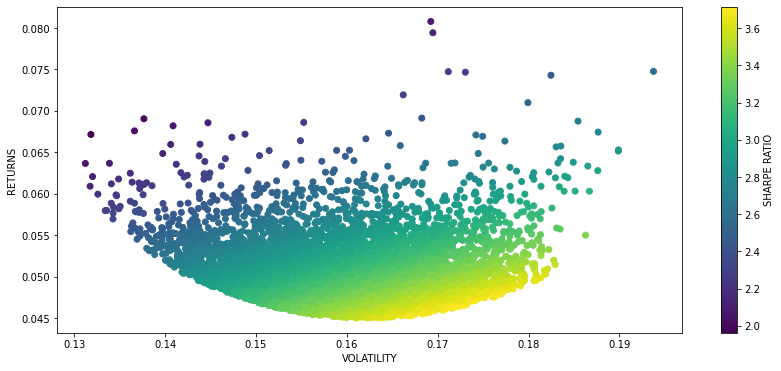

In [108]:
plt.figure(figsize=(14,6))
plt.scatter(mc_returns, mc_volatility, c=mc_sr)
plt.ylabel('RETURNS')
plt.xlabel('VOLATILITY')
plt.colorbar(label='SHARPE RATIO')

This is how the simulation looks, but where does the fronter lie? This is where the Sharpe Ratio comes at play. Let's obtain the maximum value for 'mc_sr' and the values at such index position. That should show us the optimal weights (expressed in percentual terms) for the assets in this portfolio. Given this simulation, most of the money shpuld be put on CostCo, followed by the Walt Disney Company and Nike.

In [110]:
optimal_weights = mc_weights[np.argmax(mc_sr)]
optimal_weights

array([0.13028314, 0.09764405, 0.08696815, 0.339556  , 0.34554865])